In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [1]:
df = pd.read_csv('Alcohol_Sales.csv', index_col='Date', parse_dates=True)

NameError: name 'pd' is not defined

In [ ]:
print(df.head())
print(df.info())
print(df.describe())


           Daily minimum temperatures
Date                                 
1981-01-01                       20.7
1981-01-02                       17.9
1981-01-03                       18.8
1981-01-04                       14.6
1981-01-05                       15.8
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Daily minimum temperatures  3650 non-null   object
dtypes: object(1)
memory usage: 57.0+ KB
None
       Daily minimum temperatures
count                        3650
unique                        230
top                            11
freq                           51


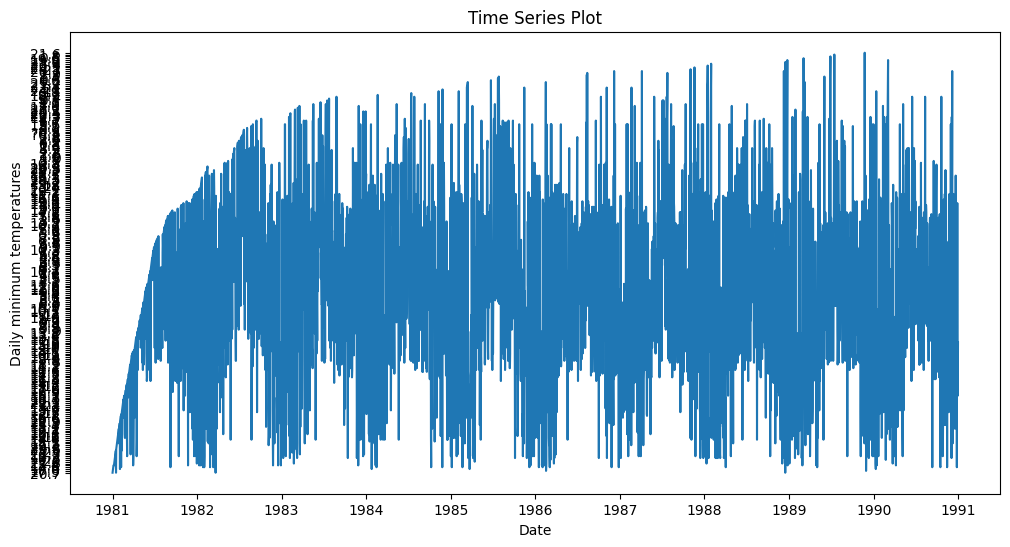

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily minimum temperatures'])  # Specify x and y data explicitly
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Daily minimum temperatures')
plt.show()


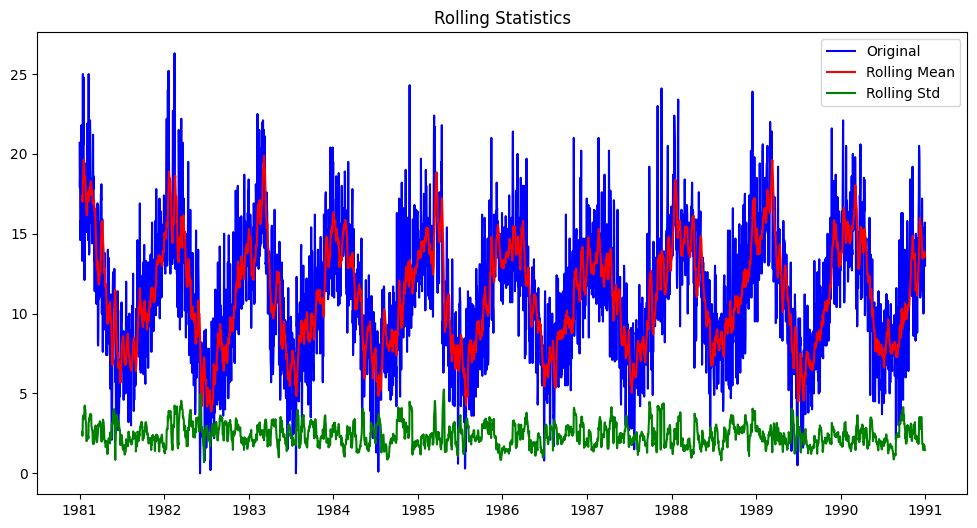

In [ ]:
# Convert 'Daily minimum temperatures' column to numeric, handling errors
df['Daily minimum temperatures'] = pd.to_numeric(df['Daily minimum temperatures'].str.replace('?', ''), errors='coerce')

#calculate rolling statistics
rolling_mean = df['Daily minimum temperatures'].rolling(window=12).mean()
rolling_std = df['Daily minimum temperatures'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(df['Daily minimum temperatures'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='green', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Statistics')
plt.show()

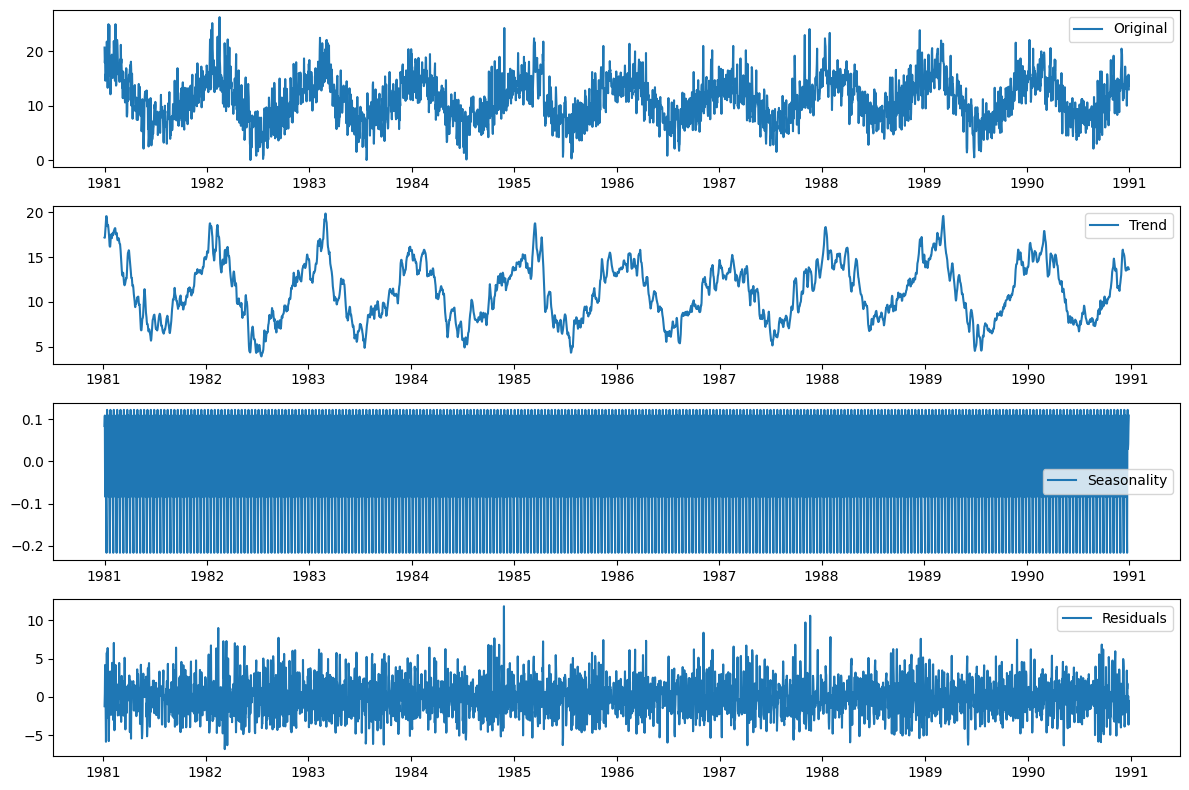

In [ ]:
decomposition = seasonal_decompose(df, model='additive', period=12)  # Adjust period as needed

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

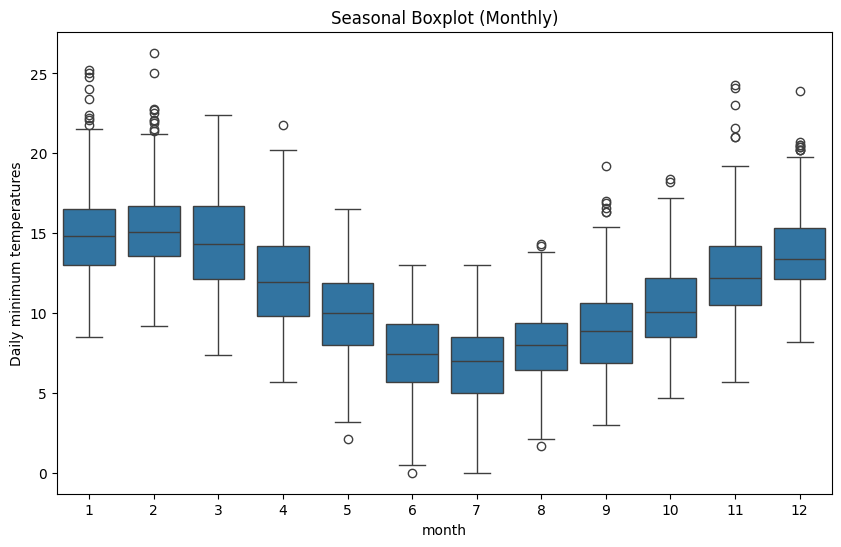

In [ ]:
df['month'] = df.index.month
fig, ax = plt.subplots(figsize=(10, 6))
# Use 'Daily minimum temperatures' instead of 'Value' for the y-axis
sns.boxplot(x='month', y='Daily minimum temperatures', data=df, ax=ax)
ax.set_title('Seasonal Boxplot (Monthly)')
plt.show()

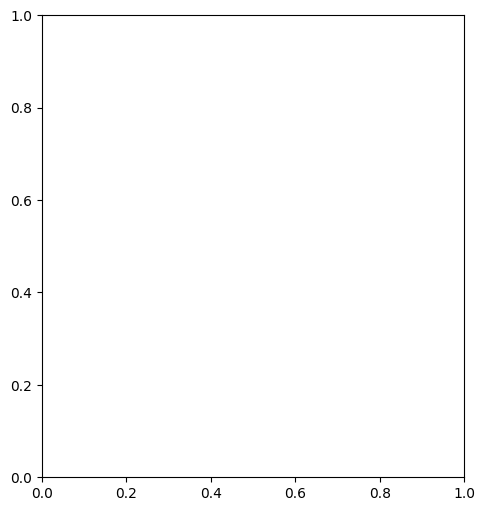

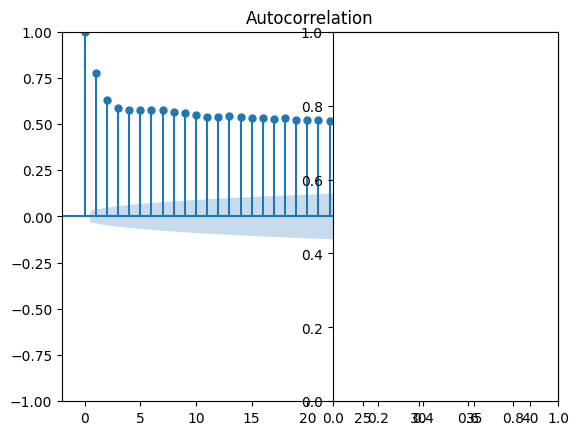

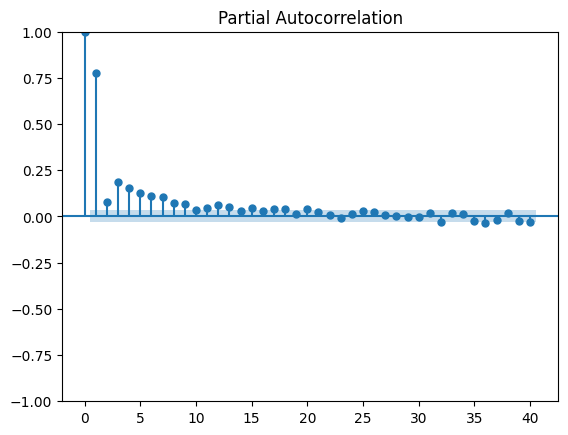

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
# Select the 'Daily minimum temperatures' column for ACF plot
plot_acf(df['Daily minimum temperatures'], lags=40)
plt.subplot(122)
# Select the 'Daily minimum temperatures' column for PACF plot
plot_pacf(df['Daily minimum temperatures'], lags=40)
plt.show()

In [ ]:
def stationarity_test(timeseries):
    """
    Performs the Dickey-Fuller test to check for stationarity.

    Args:
      timeseries: The time series data.

    Returns:
      A tuple containing the test statistic, p-value, lags used,
      number of observations used, critical values, and the
      results of the test (whether the series is stationary or not).
    """
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value',
                                         '#Lags Used',
                                         'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Conclusion: Series is likely stationary.")
    else:
        print("Conclusion: Series is likely non-stationary.")
        # %%
        # Differencing to achieve stationarity
        # Change 'Value' to 'Daily minimum temperatures'
        df['Value_diff'] = df['Daily minimum temperatures'].diff().dropna()
        stationarity_test(df['Value_diff'].dropna())

        plt.figure(figsize=(12,6))
        plt.plot(df['Value_diff'], label='Differenced Data')
        plt.title('First Order Differencing')
        plt.legend()
        plt.show()

# Change 'Value' to 'Daily minimum temperatures' when calling the function
stationarity_test(df['Daily minimum temperatures'])

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64
Conclusion: Series is likely stationary.
